Tamanna Ananna <br />
ta2642

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from mpl_toolkits import mplot3d
from numpy.random import uniform


import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParamsDefault
import tensorflow as tf
import keras
from keras import initializers
import keras.layers as layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Dropout 
from keras.layers import LeakyReLU, Flatten, AveragePooling2D, BatchNormalization
from keras import backend as K
from keras.datasets import mnist

from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard


from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.image import grayscale_to_rgb
from tensorflow import expand_dims


from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError
import time


Xavier/Glorot if tanh activation
He initialization recommended if the activation is ReLu

5 hidden layers, 100 units each
output- sigmoid activation, binary classification

Data: 100 random points, 10 features each. Negative: points situated within half of the radius of the ball (0)
Rest:  positive cases (1)

In [2]:
#Code from blog 2

sns.set()
def grid_axes_it(n_plots, n_cols=3, enumerate=False, fig=None):
    """
    Iterate through Axes objects on a grid with n_cols columns and as many
    rows as needed to accommodate n_plots many plots.
    Args:
        n_plots: Number of plots to plot onto figure.
        n_cols: Number of columns to divide the figure into.
        fig: Optional figure reference.
    Yields:
        n_plots many Axes objects on a grid.
    """
    n_rows = n_plots / n_cols + int(n_plots % n_cols > 0)

    if not fig:
        default_figsize = rcParamsDefault['figure.figsize']
        fig = plt.figure(figsize=(
            default_figsize[0] * n_cols,
            default_figsize[1] * n_rows
        ))

    for i in range(1, n_plots + 1):
        ax = plt.subplot(n_rows, n_cols, i)
        yield ax


def create_mlp_model(
    n_hidden_layers,
    dim_layer,
    input_shape,
    n_classes,
    kernel_initializer,
    bias_initializer,
    activation,
):
    """Create Multi-Layer Perceptron with given parameters."""
    model = Sequential()
    model.add(Dense(dim_layer, input_shape=input_shape, kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    for i in range(n_hidden_layers):
        model.add(Dense(dim_layer, activation=activation, kernel_initializer=kernel_initializer,
                        bias_initializer=bias_initializer))
    model.add(Dense(n_classes, activation='softmax', kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    return model



def compile_model(model):
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=RMSprop(),
                  metrics=['accuracy'])
    return model


In [3]:
seed = 10

# Number of points to plot
n_train = 1000
n_test = 100
n_classes = 10

# Network params
n_hidden_layers = 5
dim_layer = 100
batch_size = n_train
epochs = 1

# Load and prepare MNIST dataset.
n_train = 60000
n_test = 10000

(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_classes = len(np.unique(y_test))
data_dim = 28 * 28

x_train = x_train.reshape(60000, 784).astype('float32')[:n_train]
x_test = x_test.reshape(10000, 784).astype('float32')[:n_train]
x_train /= 255
x_test /= 255

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

11501568/11490434 [==============================] - 0s 0us/step


# Sigmoid and TanH Activation

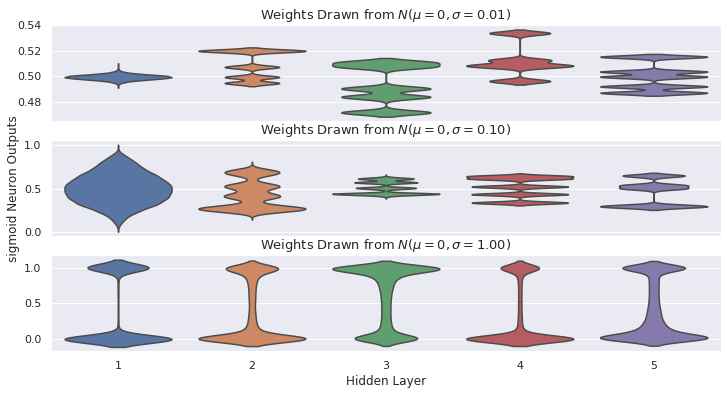

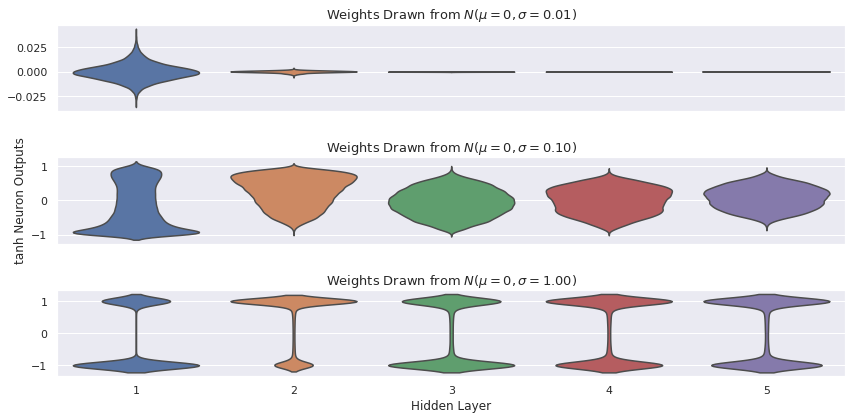

In [4]:
# Run the data through a few MLP models and save the activations from
# each layer into a Pandas DataFrame.

ACTIVATIONS = ['sigmoid','tanh']

sigmas = [0.010, 0.1, 1.00]
for activation in ACTIVATIONS:
  rows = []
  for stddev in sigmas:
    init = initializers.RandomNormal(mean=0.0, stddev=stddev, seed=seed)
    model = create_mlp_model(
        n_hidden_layers,
        dim_layer,
        (data_dim,),
        n_classes,
        init,
        'zeros',
        activation
    )
    compile_model(model)
    
    output_elts = []
    for layer in model.layers:
      keras_function = K.function([model.input], [layer.output])
      output_elts.append(keras_function([x_test]))
    n_layers = len(model.layers)
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in np.array(out).ravel()[::20]:
                rows.append([i, stddev, out_i])

  df = pd.DataFrame(rows, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

    # Plot previously saved activations from the 5 hidden layers
    # using different initialization schemes.
  fig = plt.figure(figsize=(12, 6))
  axes = grid_axes_it(len(sigmas), 1, fig=fig)
  for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title('Weights Drawn from $N(\mu = 0, \sigma = {%.2f})$' % sig, fontsize=13)

    if sig == sigmas[1]:
      ax.set_ylabel(str(activation) + ' Neuron Outputs')
    if sig != sigmas[-1]:
      ax.set_xticklabels(())
    else:
      ax.set_xlabel("Hidden Layer")

plt.tight_layout()
plt.show()



# Standard Normalization
As we can see for sigmoid activations, for stdev of 0.01, the mean is around 0.5 and they are all within a narrow range. 
With stdev of 0.1, we see the range being better, but they seem to collapse.

At stdev of 1, the activations are stretched at both ends.

For tanh, as we can clearly see for standard deviation of 0.01, the activations are basically zero.



For standard deviation of 1, wee see the activations are collapsing at each end of 1 and -1

For standard deviaiton of 0.1, the activations look pretty well distributed from -1 and 1 and are relatively consistent throughtout the layers in comparison, though they do seem to get smaller at the later layers.


The activations with Glorot initialization looks beautiful. Well distributed and mostly retaining the value throughout the layers

In [5]:
# Code for activations- plot_activations()

def plot_activations(activation, init, init_name):

  rows = []
  model = create_mlp_model(
  n_hidden_layers,
      dim_layer,
      (data_dim,),
      n_classes,
      init,
      'zeros',
      activation
  )
  compile_model(model)

  output_elts = []
  for layer in model.layers:
    keras_function = K.function([model.input], [layer.output])
    output_elts.append(keras_function([x_test]))

  n_layers = len(model.layers)
  i_output_layer = n_layers - 1

  for i, out in enumerate(output_elts[:-1]):
      if i > 0 and i != i_output_layer:
          for out_i in np.array(out).ravel()[::20]:
              rows.append([i,  out_i])

  df = pd.DataFrame(rows, columns=['Hidden Layer', 'Output'])

  # Plot previously saved activations from the 5 hidden layers
  # using different initialization schemes.
  fig = plt.figure(figsize=(12, 6))
  axes = grid_axes_it(1, 1, fig=fig)


  ax = next(axes)
  ddf = df
  sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

  ax.set_xlabel('')
  ax.set_ylabel('')

  ax.set_title('Weights Drawn from ' + str(init_name), fontsize=13)


  ax.set_ylabel(str(activation) + ' Neuron Outputs')

  ax.set_xlabel("Hidden Layer")

  plt.tight_layout()
  plt.show()

# Glorot/Xavier Normalization with Sigmoid Activation


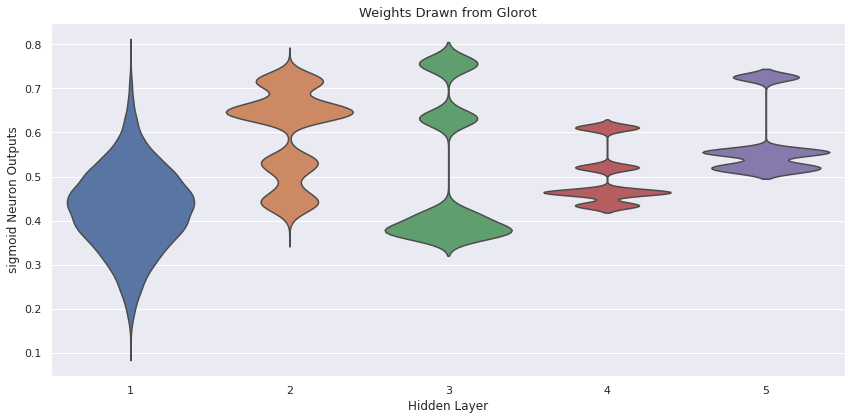

In [6]:
plot_activations('sigmoid', initializers.GlorotNormal(), 'Glorot')

# Glorot/Xavier Normalization with TanH Activation

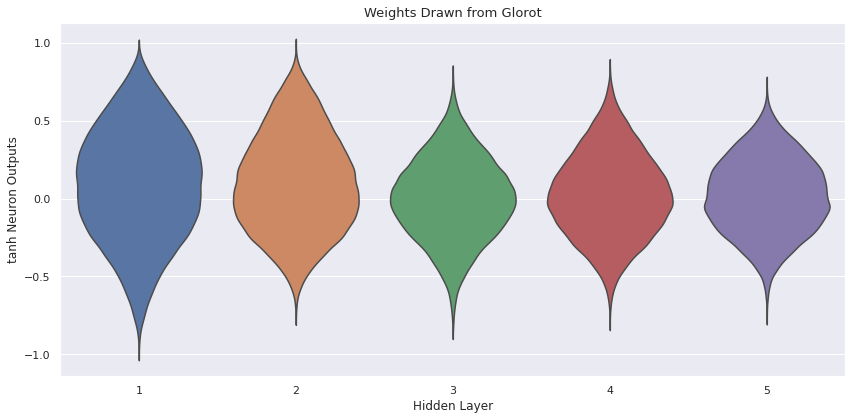

In [7]:
plot_activations('tanh', initializers.GlorotNormal(), 'Glorot')

The activations with Glorot initialization for tanh looks beautiful. Well distributed and mostly retaining the value throughout the layers

## ReLu Activation with Glorot vs He

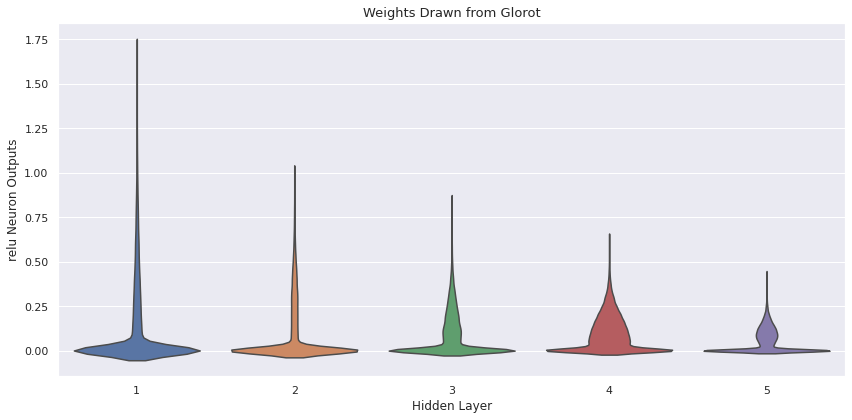

In [ ]:
plot_activations('relu', initializers.GlorotNormal(), 'Glorot')

With GLorot, ReLu activations are decreasing after each layer, so they are vanishing.

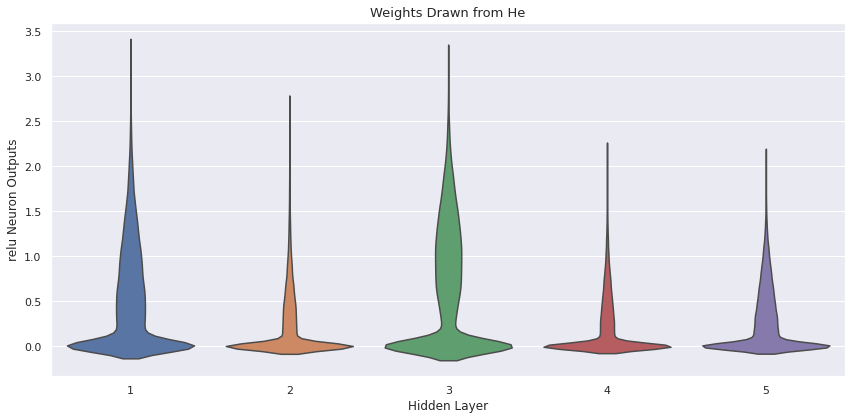

In [ ]:
plot_activations('relu', initializers.HeNormal(), 'He')

With He Activation, the activations are staying more stable and not vanishing.

# Dying RelU

We try to predict the constant function f(x) = xsin(5x)


We use a 10-layer ReLU network with width 2 (hidden units per layer). Using minibatch of 64 and drawing training data uniformly from [− sqrt(7), sqrt(7)]. We do 1000 independent training simulations each with 3,000 training point


In [ ]:

seed = 11

# Number of points to plot
n_train = 3000
n_sims = 100

def f(x):
  return x*np.sin(5*x)

n_hidden_layers = 9

def build_model():
  dim_layer = 2
  activation = 'relu'
  init = initializers.HeNormal()
  bias_initializer = 'zeros'

  model = Sequential()
  model.add(Dense(dim_layer, input_shape = (1,), kernel_initializer=init,
                    bias_initializer= 'zeros'))
  for i in range(n_hidden_layers):
      model.add(Dense(dim_layer, activation='relu', kernel_initializer=init,
                      bias_initializer='zeros'))

  model.add(Dense(1))

  model.compile(loss=keras.losses.MeanSquaredError(),
                    optimizer=Adam(),
                    metrics=['accuracy'])
  return model


collapse = 0
callback = EarlyStopping()

#run simulations
for sim in range(n_sims):
  x_train = np.random.uniform(- np.sqrt(7), np.sqrt(7),n_train)
  y_train = f(x_train)

  model = build_model()
  model.fit(x_train, y_train, epochs = 10, batch_size = 64, 
            callbacks=[callback],validation_split = 0.2, verbose = 0)
  rows = []
  output_elts = []

  for layer in model.layers:
    activations = K.function([model.input], [layer.output])
    output_elts.append(activations([x_train]))

  n_layers = len(model.layers)
  i_output_layer = n_layers - 1 #last layer

  #sum the activations. if it sums to 0, then network has collapsed
  for i, out in enumerate(output_elts[:-1]): 
    #if it's not the first or last layer
    if i > 0 and i != i_output_layer:
      sum_act = np.sum(np.array(out).ravel())
      if sum_act == 0.0:
        collapse +=1
        break

c_rate = collapse*1.0/n_sims
print(c_rate)

0.91


In [16]:
print('Percent of simulations that resulted in network collapse: %.2f' % (c_rate*100))

Percent of simulations that resulted in network collapse: 91.00


0.942

between 90% to 94.3% of the simulations **collapsed**

In [ ]:
#Activations plot

for layer in model.layers:
  keras_function = K.function([model.input], [layer.output])
  output_elts.append(keras_function([x_train]))

n_layers = len(model.layers)
i_output_layer = n_layers - 1

for i, out in enumerate(output_elts[:-1]): #skip last one
    if i > 0 and i != i_output_layer:
      print(out[0][0])
      for out_i in np.array(out).ravel()[::20]: #skip to 20th each
        rows.append([i, out_i])

df = pd.DataFrame(rows, columns=['Hidden Layer', 'Output']) 

fig = plt.figure(figsize=(12, 6))
axes = grid_axes_it(1, 1, fig=fig)

ax = next(axes)
ddf = df
sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

ax.set_xlabel('')
ax.set_ylabel('')

ax.set_title('Weights Drawn from He', fontsize=13)


ax.set_ylabel('ReLu Neuron Outputs')

ax.set_xlabel("Hidden Layer")

plt.tight_layout()
plt.show()

# Leaky ReLu instead of ReLu

In [ ]:

seed = 11

# Number of points to plot
n_train = 3000
n_sims = 100

def f(x):
  return x*np.sin(5*x)

n_hidden_layers = 9

def build_model():
  dim_layer = 2
  #activation = 'relu'
  init = initializers.HeNormal()
  bias_initializer = 'zeros'

  model = Sequential()
  model.add(Dense(dim_layer, input_shape = (1,), kernel_initializer=init,
                    bias_initializer= 'zeros'))
  
  for i in range(n_hidden_layers):
      model.add(Dense(dim_layer, activation=LeakyReLU(alpha=0.01), 
                kernel_initializer=init,
                bias_initializer='zeros'))

  model.add(Dense(1))

  model.compile(loss=keras.losses.MeanSquaredError(),
                    optimizer=Adam(),
                    metrics=['accuracy'])
  return model


collapse = 0
callback = EarlyStopping()

#run simulations
for sim in range(n_sims):
  x_train = np.random.uniform(- np.sqrt(7), np.sqrt(7),n_train)
  y_train = f(x_train)

  model = build_model()
  model.fit(x_train, y_train, epochs = 10, batch_size = 64, 
            callbacks=[callback],validation_split = 0.2, verbose = 0)
  rows = []
  output_elts = []

  for layer in model.layers:
    activations = K.function([model.input], [layer.output])
    output_elts.append(activations([x_train]))

  n_layers = len(model.layers)
  i_output_layer = n_layers - 1 #last layer

  #sum the activations. if it sums to 0, then network has collapsed
  for i, out in enumerate(output_elts[:-1]): 
    #if it's not the first or last layer
    if i > 0 and i != i_output_layer:
      sum_act = np.sum(np.array(out).ravel())
      if sum_act == 0.0:
        collapse +=1
        break

c_rate = collapse*1.0/n_sims
print(c_rate)

0.0


In [18]:
print('LeakyRelu, Percent of simulations that resulted in network collapse: %.2f' % (c_rate*100))

LeakyRelu, Percent of simulations that resulted in network collapse: 0.00


0% Collapsed with leakyRelu

Leaky ReLu helps preventing dying neurons because it adds very small gradient for inputs less than 0. As a result, these neurons remain active.